In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset/dataset_harga_beras.xlsx
/kaggle/input/dataset/dataset_hama.xlsx
/kaggle/input/dataset/dataset_rainfall_all.xlsx


In [2]:
# pip install -q tensorflow keras

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import random
import tensorflow as tf
from time import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from datetime import timedelta
from tqdm.notebook import tqdm
from time import time

2025-05-03 08:12:47.418400: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746259967.609957      77 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746259967.666021      77 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
#  Set Seed untuk Reproducibility 
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

**REGRESI**

In [5]:
# Load & preprocess data
df = pd.read_excel("/kaggle/input/dataset/dataset_rainfall_all.xlsx", sheet_name="Sheet1")
df['tanggal'] = pd.to_datetime(df['tanggal'], dayfirst=True)
df = df.sort_values('tanggal')
features = ['tavg', 'rh_avg', 'ss']
target = 'rr'

# Cek jumlah missing value sebelum preprocessing
missing_before = df[features + [target]].isnull().sum()
print("Missing value sebelum preprocessing:")
print(missing_before)

df[features + [target]] = df[features + [target]].interpolate(method='linear').bfill().ffill()


# Cek jumlah missing value setelah preprocessing
missing_after = df[features + [target]].isnull().sum()
print("\nMissing value setelah preprocessing:")
print(missing_after)

# Statistik deskriptif sebelum scaling
desc_before = df[features + [target]].describe()
print("\nStatistik Deskriptif (sebelum scaling):")
print(desc_before)

# Normalize
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(df[features])
y_scaled = scaler_y.fit_transform(df[[target]])

# Create dataset
def create_dataset(X, y, lookback=30):
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i-lookback:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_dataset(X_scaled, y_scaled, lookback=30)

print(f"\nJumlah sampel setelah sliding window: {X_seq.shape[0]} sampel")
print(f"Dimensi input: {X_seq.shape}")
print(f"Dimensi output: {y_seq.shape}")

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False, random_state = 42)

# Build and train LSTM regression model
model_reg = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(1)
])
model_reg.compile(optimizer='adam', loss=MeanSquaredError())

start_time = time()
model_reg.fit(X_train, y_train, epochs=50, batch_size=12, validation_split=0.1, verbose=0)
training_time = time() - start_time

# Evaluate
y_pred_scaled = model_reg.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + 1e-8))

print(f"MAE: {mae:.2f} mm")
print(f"R² Score: {r2:.4f}")
print(f"SMAPE: {smape:.2f}%")
print(f"Training Time: {training_time:.2f} seconds")

#  Save Model and Scalers for Future Use 
from tensorflow.keras.models import save_model
import joblib

save_model(model_reg, "lstm_rainfall_model.h5")
joblib.dump(scaler_x, "scaler_rainfall_input")
joblib.dump(scaler_y, "scaler_rainfall_output")

Missing value sebelum preprocessing:
tavg       26
rh_avg     25
ss        144
rr        345
dtype: int64

Missing value setelah preprocessing:
tavg      0
rh_avg    0
ss        0
rr        0
dtype: int64

Statistik Deskriptif (sebelum scaling):
              tavg       rh_avg           ss           rr
count  3683.000000  3683.000000  3683.000000  3683.000000
mean     26.663223    85.271111     4.599403    13.847312
std       1.000142     4.665379     2.811743    23.932179
min      22.500000    61.000000     0.000000     0.000000
25%      26.100000    82.000000     2.300000     0.000000
50%      26.700000    85.000000     4.600000     3.500000
75%      27.300000    88.000000     6.800000    17.500000
max      31.500000    99.000000    11.600000   242.400000

Jumlah sampel setelah sliding window: 3653 sampel
Dimensi input: (3653, 30, 3)
Dimensi output: (3653, 1)


I0000 00:00:1746259981.313873      77 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746259981.314558      77 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1746259984.724732     126 cuda_dnn.cc:529] Loaded cuDNN version 90300


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
MAE: 12.92 mm
R² Score: 0.1654
SMAPE: 125.38%
Training Time: 46.48 seconds


['scaler_rainfall_output']

In [ ]:
# Plothasil prediksi vs aktual
plt.figure(figsize=(10,6))
plt.plot(y_true, label='Aktual')
plt.plot(y_pred, label='Prediksi')
plt.title('Perbandingan Curah Hujan Aktual dan Prediksi')
plt.xlabel('Hari')
plt.ylabel('Curah Hujan (mm)')
plt.legend()
plt.grid(True)
plt.show()

**CLASSIFICATION**

In [7]:
#  Set Seed for Reproducibility 
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

#  Load & Preprocess Data
df = pd.read_excel("/kaggle/input/dataset/dataset_rainfall_all.xlsx", sheet_name="Sheet1")
df['tanggal'] = pd.to_datetime(df['tanggal'], dayfirst=True)
df = df.sort_values('tanggal')

# features = ['tavg', 'rh_avg', 'ff_avg', 'ss']
features = ['tavg', 'rh_avg', 'ss']
target = 'rr'

df[features + [target]] = df[features + [target]].interpolate(method='linear').bfill().ffill()

#  Create Binary Label: Hujan >= 5mm => 1; Tidak => 0 
df['rr_label'] = df['rr'].apply(lambda x: 1 if x >= 5 else 0)

#  Normalize Features 
scaler_x = MinMaxScaler()
X_scaled = scaler_x.fit_transform(df[features])
y_binary = df['rr_label'].values

#  Save Scaler for Future Use 
joblib.dump(scaler_x, "scaler_rainfall_input")

#  Create Dataset with Lookback = 30 (Best Grid Search) 
def create_dataset(X, y, lookback=30):
    Xs, ys = [], []
    for i in range(lookback, len(X)):
        Xs.append(X[i-lookback:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_dataset(X_scaled, y_binary, lookback=30)

#  Split Dataset 
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False, random_state=SEED)

#  Build and Train LSTM Classifier 
model_cls = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model_cls.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

start_time = time()
model_cls.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.1, verbose=0)
training_time = time() - start_time

#  Evaluate Best Model 
y_pred_prob = model_cls.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f" Best LSTM Classification Model (Grid Search)")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Training Time: {training_time:.2f} seconds")

#  Save Model 
save_model(model_cls, "lstm_classification_model.h5")
print("Model classification berhasil disimpan ke lstm_classification_model.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
 Best LSTM Classification Model (Grid Search)
Accuracy: 0.6895
Precision: 0.6775
Recall: 0.6190
F1 Score: 0.6470
Training Time: 23.31 seconds
Model classification berhasil disimpan ke lstm_classification_model.h5


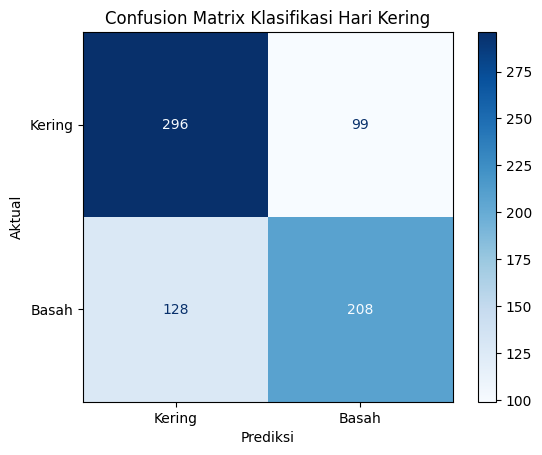

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Buat confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Tampilkan confusion matrix dengan label 0 = Kering, 1 = Basah
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Kering", "Basah"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix Klasifikasi Hari Kering")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.grid(False)
plt.show()

**ROLLING CODE**

In [9]:
#Set Seed for Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

#Load Model dan Scaler
print("Loading model dan scaler...")
model_reg = load_model("/kaggle/working/lstm_rainfall_model.h5")
model_cls = load_model("/kaggle/working/lstm_classification_model.h5")
scaler_x = joblib.load("/kaggle/working/scaler_rainfall_input")
scaler_y = joblib.load("/kaggle/working/scaler_rainfall_output")
print("Model dan scaler berhasil dimuat!")

# Load Dataset 
print("Loading dataset...")
df = pd.read_excel("/kaggle/input/dataset/dataset_rainfall_all.xlsx", sheet_name="Sheet1")
df['tanggal'] = pd.to_datetime(df['tanggal'], dayfirst=True)
df = df.sort_values('tanggal').reset_index(drop=True)

features = ['tavg', 'rh_avg', 'ss']
target = 'rr'

# Interpolasi missing value
df[features + [target]] = df[features + [target]].interpolate(method='linear').bfill().ffill()

# Hitung climatology
df['month_day'] = df['tanggal'].dt.strftime('%m-%d')
climatology = df.groupby('month_day')[features].mean()
print("Dataset dan climatology berhasil dimuat!")

# Rolling Forecast Setup 
lookback = 30
start_date = pd.to_datetime("2014-05-01")
end_date = pd.to_datetime("2025-07-31")
forecast_horizon = (end_date - start_date).days + 90  # 90 hari buffer untuk prediksi lebih jauh
last_actual_date = df['tanggal'].max()

# Build Initial Window 
print("Membangun initial window...")
window = []
for d in pd.date_range(end=start_date - timedelta(days=1), periods=lookback):
    match = df.loc[df['tanggal'] == d, features]
    if not match.empty:
        vals = match.values[0]
    else:
        md = d.strftime('%m-%d')
        vals = climatology.loc[md].values
    window.append(vals)
window = np.array(window)

# Rolling Forecast Loop 
print(f"Mulai rolling forecast {forecast_horizon} hari...")
X_seq = scaler_x.transform(window).reshape(1, lookback, len(features))
rolling_forecast = []

rolling_dates = pd.date_range(start=start_date, periods=forecast_horizon)

for t in tqdm(rolling_dates, desc="Rolling Forecast"):
    #Prediksi Curah Hujan 
    pred_reg_scaled = model_reg.predict(X_seq, verbose=0)
    pred_rr = scaler_y.inverse_transform(pred_reg_scaled)[0, 0]

    #Prediksi Status Kering / Hujan 
    pred_cls = model_cls.predict(X_seq, verbose=0)
    pred_cls_bin = int(pred_cls[0, 0] >= 0.5)

    rolling_forecast.append({
        "Tanggal": t,
        "Rainfall": pred_rr,
        "RainLabel": pred_cls_bin
    })

    # Update Input untuk Next Step
    if t <= last_actual_date:
        next_vals = df.loc[df['tanggal'] == t, features]
        if not next_vals.empty:
            next_vals = next_vals.values[0]
        else:
            md = t.strftime('%m-%d')
            next_vals = climatology.loc[md].values
    else:
        md = t.strftime('%m-%d')
        next_vals = climatology.loc[md].values

    next_input = scaler_x.transform(pd.DataFrame(next_vals.reshape(1, -1), columns=features))
    new_window = np.vstack([X_seq[0, 1:, :], next_input])
    X_seq = new_window.reshape(1, lookback, len(features))

# Save Rolling Forecast Result
rolling_df = pd.DataFrame(rolling_forecast)
rolling_df.to_csv("/kaggle/working/hasil_rolling_forecast_2014_2025.csv", index=False, encoding="utf-8-sig")
print(f"\nRolling forecast selesai! Hasil {len(rolling_df)} hari disimpan di 'hasil_rolling_forecast_2014_2025.csv'.")

Loading model dan scaler...
Model dan scaler berhasil dimuat!
Loading dataset...
Dataset dan climatology berhasil dimuat!
Membangun initial window...
Mulai rolling forecast 4199 hari...


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Rolling Forecast:   0%|          | 0/4199 [00:00<?, ?it/s]


Rolling forecast selesai! Hasil 4199 hari disimpan di 'hasil_rolling_forecast_2014_2025.csv'.


In [10]:
# Tampilkan cuplikan data klimatologi untuk laporan 
cuplikan_klimatologi = climatology.reset_index().head(5)
cuplikan_klimatologi.columns = ['Month-Day', 'tavg (°C)', 'rh_avg (%)', 'ss (jam)']

print("Cuplikan Data Klimatologi (5 baris pertama):")
display(cuplikan_klimatologi)

Cuplikan Data Klimatologi (5 baris pertama):


,Month-Day,tavg (°C),rh_avg (%),ss (jam)
0,01-01,26.57,85.6,5.135
1,01-02,26.57,85.2,4.150
2,01-03,26.12,86.5,5.130
3,01-04,26.59,85.8,3.380
4,01-05,26.83,85.0,4.650


In [11]:
rolling_df.head()

,Tanggal,Rainfall,RainLabel
0,2014-05-01,13.166936,1
1,2014-05-02,7.432803,1
2,2014-05-03,12.735054,1
3,2014-05-04,17.863253,1
4,2014-05-05,8.662185,0


In [12]:
rolling_df.tail()

,Tanggal,Rainfall,RainLabel
4194,2025-10-24,14.090417,1
4195,2025-10-25,15.996126,1
4196,2025-10-26,12.439374,0
4197,2025-10-27,10.210454,0
4198,2025-10-28,13.212656,1


In [13]:
print("Jumlah total hari:", len(rolling_df))
print("Hari basah:", (rolling_df['RainLabel'] == 1).sum())
print("Hari kering:", (rolling_df['RainLabel'] == 0).sum())
print("Rata-rata prediksi curah hujan:", rolling_df['Rainfall'].mean(), "mm")
print("Maksimum prediksi curah hujan:", rolling_df['Rainfall'].max(), "mm")
print("Minimum prediksi curah hujan:", rolling_df['Rainfall'].min(), "mm")

Jumlah total hari: 4199
Hari basah: 1724
Hari kering: 2475
Rata-rata prediksi curah hujan: 11.838877 mm
Maksimum prediksi curah hujan: 75.99562072753906 mm
Minimum prediksi curah hujan: -14.832634925842285 mm


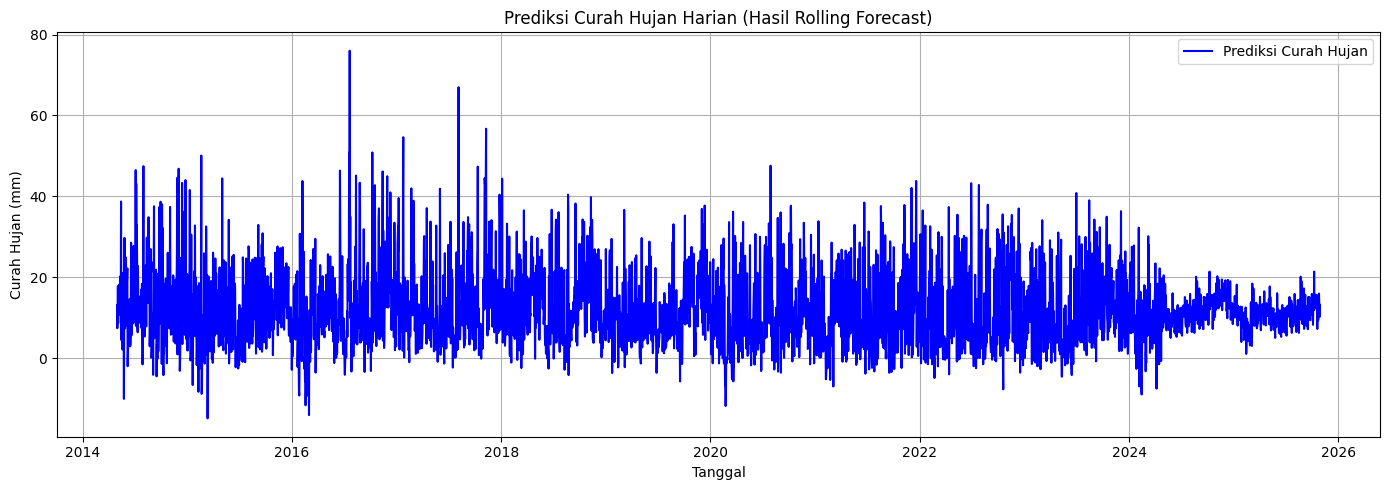

In [14]:
rolling_df = pd.read_csv("/kaggle/working/hasil_rolling_forecast_2014_2025.csv")
rolling_df['Tanggal'] = pd.to_datetime(rolling_df['Tanggal'])

plt.figure(figsize=(14, 5))
plt.plot(rolling_df['Tanggal'], rolling_df['Rainfall'], label='Prediksi Curah Hujan', color='blue')
plt.title("Prediksi Curah Hujan Harian (Hasil Rolling Forecast)")
plt.xlabel("Tanggal")
plt.ylabel("Curah Hujan (mm)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

**TERAPKAN RULES KE HASIL ROLLING**

In [15]:
# Fungsi Max Hari Kering 
def max_hari_kering(rain_label_array):
    count = max_count = 0
    for v in rain_label_array:
        if v == 0:
            count += 1
            max_count = max(max_count, count)
        else:
            count = 0
    return max_count

def generate_dss(rolling_df, start_date, end_date, save_path):
    tanggal_tanam_range = pd.date_range(start=start_date, end=end_date)

    # Batas tanggal tanam terakhir yang masih bisa punya prediksi 90 hari ke depan
    max_valid_tanam = rolling_df['Tanggal'].max() - timedelta(days=89)
    tanggal_tanam_range = tanggal_tanam_range[tanggal_tanam_range <= max_valid_tanam]

    dss_results = []

    print(f"Menghitung DSS dari {start_date.date()} sampai {min(end_date, max_valid_tanam).date()}...")
    for tanam_date in tqdm(tanggal_tanam_range, desc=f"Hitung DSS {start_date.year}-{end_date.year}"):
        future = rolling_df[rolling_df['Tanggal'] >= tanam_date].reset_index(drop=True)

        if len(future) >= 30:  # tetap cek karena fitur RBS hanya butuh sampai 30 hari ke depan
            total_5 = future.loc[:4, 'Rainfall'].sum()
            total_30 = future.loc[:29, 'Rainfall'].sum()
            max_dry15 = max_hari_kering(future.loc[:14, 'RainLabel'].values)

            dss_results.append({
                "Tanggal": tanam_date,
                "Total 5 Hari (mm)": round(total_5, 1),
                "Max Kering 15 Hari": max_dry15,
                "Total 30 Hari (mm)": round(total_30, 1)
            })

    df_dss = pd.DataFrame(dss_results)
    df_dss.to_csv(save_path, index=False, encoding="utf-8-sig")
    print(f"Hasil DSS disimpan di {save_path}. Jumlah tanggal: {len(df_dss)}")

# Generate untuk 2014-2024 (Evaluasi) 
generate_dss(
    rolling_df=rolling_df,
    start_date=pd.to_datetime("2014-05-01"),  # Mulai tanam setelah window cukup
    end_date=pd.to_datetime("2024-04-30"),
    save_path="/kaggle/working/hasil_dss_evaluasi_2014_2024.csv"
)

# Generate untuk 2024-2025 (Forecast) 
generate_dss(
    rolling_df=rolling_df,
    start_date=pd.to_datetime("2024-05-01"),
    end_date=pd.to_datetime("2025-07-31"),
    save_path="/kaggle/working/hasil_dss_forecast_2024_2025.csv"
)

Menghitung DSS dari 2014-05-01 sampai 2024-04-30...


Hitung DSS 2014-2024:   0%|          | 0/3653 [00:00<?, ?it/s]

Hasil DSS disimpan di /kaggle/working/hasil_dss_evaluasi_2014_2024.csv. Jumlah tanggal: 3653
Menghitung DSS dari 2024-05-01 sampai 2025-07-31...


Hitung DSS 2024-2025:   0%|          | 0/457 [00:00<?, ?it/s]

Hasil DSS disimpan di /kaggle/working/hasil_dss_forecast_2024_2025.csv. Jumlah tanggal: 457


In [16]:
rolling_df['Tanggal'].max()

Timestamp('2025-10-28 00:00:00')

In [17]:
rolling_df.head()

,Tanggal,Rainfall,RainLabel
0,2014-05-01,13.166936,1
1,2014-05-02,7.432803,1
2,2014-05-03,12.735054,1
3,2014-05-04,17.863253,1
4,2014-05-05,8.662185,0


In [18]:
rolling_df.tail()

,Tanggal,Rainfall,RainLabel
4194,2025-10-24,14.090417,1
4195,2025-10-25,15.996126,1
4196,2025-10-26,12.439374,0
4197,2025-10-27,10.210454,0
4198,2025-10-28,13.212656,1


**GABUNG HASIL MAU DILABEL RBS**

In [19]:
# Load hasil DSS evaluasi dan forecast 
dss_eval = pd.read_csv("/kaggle/working/hasil_dss_evaluasi_2014_2024.csv", parse_dates=['Tanggal'])
dss_forecast = pd.read_csv("/kaggle/working/hasil_dss_forecast_2024_2025.csv", parse_dates=['Tanggal'])

#  Gabungkan 
dss_all = pd.concat([dss_eval, dss_forecast], axis=0).reset_index(drop=True)

# Urutkan berdasarkan Tanggal 
dss_all = dss_all.sort_values('Tanggal').reset_index(drop=True)

# Cek hasil gabungan 
print(f"Total tanggal gabungan: {len(dss_all)}")
display(dss_all.head())
display(dss_all.tail())

# Simpan file gabungan sementara 
dss_all.to_csv("/kaggle/working/hasil_dss_gabungan_2014_2025.csv", index=False, encoding="utf-8-sig")
print("Gabungan DSS disimpan di /kaggle/working/hasil_dss_gabungan_2014_2025.csv")

Total tanggal gabungan: 4110


,Tanggal,Total 5 Hari (mm),Max Kering 15 Hari,Total 30 Hari (mm)
0,2014-05-01,59.9,2,389.4
1,2014-05-02,62.8,2,384.1
2,2014-05-03,72.3,2,401.6
3,2014-05-04,74.8,2,404.2
4,2014-05-05,75.2,2,396.2


,Tanggal,Total 5 Hari (mm),Max Kering 15 Hari,Total 30 Hari (mm)
4105,2025-07-27,46.6,9,342.6
4106,2025-07-28,54.6,10,353.7
4107,2025-07-29,58.9,10,356.7
4108,2025-07-30,58.3,10,354.5
4109,2025-07-31,60.7,10,355.8


Gabungan DSS disimpan di /kaggle/working/hasil_dss_gabungan_2014_2025.csv


**LABEL HASIL ROLLING**

In [20]:
# Load gabungan DSS 
dss_all = pd.read_csv("/kaggle/working/hasil_dss_gabungan_2014_2025.csv", parse_dates=['Tanggal'])

# Definisikan fungsi label 
def label_rbs(row):
    skor = 0
    # Total 5 Hari
    if row['Total 5 Hari (mm)'] >= 38:
        skor += 2
    elif row['Total 5 Hari (mm)'] >= 30:
        skor += 1
    # Max Kering 15 Hari
    if row['Max Kering 15 Hari'] <= 10:
        skor += 2
    elif row['Max Kering 15 Hari'] <= 14:
        skor += 1
    # Total 30 Hari
    if row['Total 30 Hari (mm)'] >= 300:
        skor += 1
    if row['Total 30 Hari (mm)'] >= 500:
        skor += 1
    # Override Hybrid
    if (
        row['Total 5 Hari (mm)'] >= 35 and
        row['Max Kering 15 Hari'] == 15 and
        row['Total 30 Hari (mm)'] >= 350
    ):
        return 'kuning'
    # Penentuan label akhir
    if skor >= 5:
        return 'hijau'
    elif skor >= 2:
        return 'kuning'
    else:
        return 'merah'

# Apply fungsi untuk membuat kolom Label RBS 
dss_all['Label RBS'] = dss_all.apply(label_rbs, axis=1)

# Sementara Label Aktual kosong dulu (nanti isi dari data aktual) 
dss_all['Label Aktual'] = None  # Disiapkan kolom kosong

#  Simpan hasilnya 
dss_all.to_csv("/kaggle/working/hasil_dss_gabungan_label.csv", index=False, encoding="utf-8-sig")
print("Label RBS berhasil diterapkan! File disimpan ke /kaggle/working/hasil_dss_gabungan_label.csv")

Label RBS berhasil diterapkan! File disimpan ke /kaggle/working/hasil_dss_gabungan_label.csv


In [21]:
dss_all.head()

,Tanggal,Total 5 Hari (mm),Max Kering 15 Hari,Total 30 Hari (mm),Label RBS,Label Aktual
0,2014-05-01,59.9,2,389.4,hijau,None
1,2014-05-02,62.8,2,384.1,hijau,None
2,2014-05-03,72.3,2,401.6,hijau,None
3,2014-05-04,74.8,2,404.2,hijau,None
4,2014-05-05,75.2,2,396.2,hijau,None


In [22]:
dss_all.tail()

,Tanggal,Total 5 Hari (mm),Max Kering 15 Hari,Total 30 Hari (mm),Label RBS,Label Aktual
4105,2025-07-27,46.6,9,342.6,hijau,None
4106,2025-07-28,54.6,10,353.7,hijau,None
4107,2025-07-29,58.9,10,356.7,hijau,None
4108,2025-07-30,58.3,10,354.5,hijau,None
4109,2025-07-31,60.7,10,355.8,hijau,None


**LABEL AKTUAL**

In [49]:
# 1. Load Data Rainfall Aktual 
df_aktual = pd.read_excel("/kaggle/input/dataset/dataset_rainfall_all.xlsx", sheet_name="Sheet1")
df_aktual['tanggal'] = pd.to_datetime(df_aktual['tanggal'], dayfirst=True)
df_aktual = df_aktual.sort_values('tanggal').reset_index(drop=True)

#  2. Load DSS yang sudah ada Label RBS 
dss_all = pd.read_csv("/kaggle/working/hasil_dss_gabungan_label.csv", parse_dates=['Tanggal'])

#  3. Fungsi untuk Hitung Max Hari Kering dari Aktual (rr < 5 mm dianggap kering) 
def max_hari_kering_aktual(rr_series):
    count = max_count = 0
    for v in rr_series:
        if v < 5:  # <= 5mm dianggap kering
            count += 1
            max_count = max(max_count, count)
        else:
            count = 0
    return max_count

#  4. Fungsi Label dari Aktual + Cek Kecepatan Angin 
def label_aktual(total_5, max_kering_15, total_30, ff_avg_15):
    # Cek dulu kecepatan angin
    if ff_avg_15 > 7:
        return 'merah'
    
    skor = 0
    if total_5 >= 38:
        skor += 2
    elif total_5 >= 30:
        skor += 1
    if max_kering_15 <= 10:
        skor += 2
    elif max_kering_15 <= 14:
        skor += 1
    if total_30 >= 300:
        skor += 1
    if total_30 >= 500:
        skor += 1
    if (total_5 >= 35 and max_kering_15 == 15 and total_30 >= 350):
        return 'kuning'
    if skor >= 5:
        return 'hijau'
    elif skor >= 2:
        return 'kuning'
    else:
        return 'merah'

# Filter DSS hanya untuk tanggal tanam yang punya cukup data aktual
dss_all = dss_all[dss_all['Tanggal'] <= pd.to_datetime("2024-04-15")].reset_index(drop=True)


#  5. Generate Label Aktual untuk Setiap Tanggal Tanam di dss_all 
print("Menghitung Label Aktual dari data curah hujan + kecepatan angin")
ff_avg_list = [] 
label_aktual_list = []
for tanggal_tanam in tqdm(dss_all['Tanggal']):
    df_future = df_aktual[df_aktual['tanggal'] >= tanggal_tanam].reset_index(drop=True)
    
    # Initialize variables
    ff_avg_15 = None
    label_now = None
    
    # Calculate metrics based on available data
    if len(df_future) >= 15:  # Need at least 15 days for ff_avg and max_dry
        ff_avg_15 = df_future.loc[:14, 'ff_avg'].mean()
        max_dry_15 = max_hari_kering_aktual(df_future.loc[:14, 'rr'])
        
        if len(df_future) >= 5:  # Need at least 5 days for total_5
            total_5 = df_future.loc[:4, 'rr'].sum()
            
            if len(df_future) >= 30:  # Need at least 30 days for total_30
                total_30 = df_future.loc[:29, 'rr'].sum()
                
                # Now we have all metrics needed for label calculation
                label_now = label_aktual(total_5, max_dry_15, total_30, ff_avg_15)
    
    # Append results
    ff_avg_list.append(round(ff_avg_15, 2) if ff_avg_15 is not None else None)
    label_aktual_list.append(label_now)

# 6. Masukkan Label Aktual ke DSS 
dss_all['ff_avg 15 Hari (m/s)'] = ff_avg_list
dss_all['Label Aktual'] = label_aktual_list


#  7. Cek Kecocokan 
dss_all['Cocok'] = dss_all['Label RBS'] == dss_all['Label Aktual']

# 8. Susun ulang kolom agar ff_avg muncul sebelum Label Aktual 

kolom_urut = [
    'Tanggal',
    'Total 5 Hari (mm)',
    'Max Kering 15 Hari',
    'Total 30 Hari (mm)',
    'ff_avg 15 Hari (m/s)',
    'Label RBS',
    'Label Aktual',
    'Cocok'
]
dss_all = dss_all[kolom_urut]


#  9. Simpan Final 
dss_all.to_csv("/kaggle/working/hasil_dss_final_label_cocok.csv", index=False, encoding="utf-8-sig")
print("Label aktual (dengan kecepatan angin) berhasil dihitung dan dibandingkan! Hasil disimpan di /kaggle/working/hasil_dss_final_label_cocok.csv")

Menghitung Label Aktual dari data curah hujan + kecepatan angin


  0%|          | 0/3638 [00:00<?, ?it/s]

Label aktual (dengan kecepatan angin) berhasil dihitung dan dibandingkan! Hasil disimpan di /kaggle/working/hasil_dss_final_label_cocok.csv


In [50]:
dss_all.head(10)

,Tanggal,Total 5 Hari (mm),Max Kering 15 Hari,Total 30 Hari (mm),ff_avg 15 Hari (m/s),Label RBS,Label Aktual,Cocok
0,2014-05-01,59.9,2,389.4,0.27,hijau,kuning,False
1,2014-05-02,62.8,2,384.1,0.33,hijau,kuning,False
2,2014-05-03,72.3,2,401.6,0.33,hijau,kuning,False
3,2014-05-04,74.8,2,404.2,0.27,hijau,kuning,False
4,2014-05-05,75.2,2,396.2,0.27,hijau,kuning,False
5,2014-05-06,82.2,2,405.2,0.27,hijau,kuning,False
6,2014-05-07,77.3,2,408.6,0.27,hijau,hijau,True
7,2014-05-08,71.2,2,413.9,0.27,hijau,hijau,True
8,2014-05-09,76.2,2,396.7,0.27,hijau,hijau,True
9,2014-05-10,69.8,2,379.8,0.27,hijau,hijau,True


In [52]:
dss_all.tail(20)

,Tanggal,Total 5 Hari (mm),Max Kering 15 Hari,Total 30 Hari (mm),ff_avg 15 Hari (m/s),Label RBS,Label Aktual,Cocok
3618,2024-03-27,55.7,6,278.9,0.93,kuning,kuning,True
3619,2024-03-28,60.2,6,285.8,0.93,kuning,kuning,True
3620,2024-03-29,71.2,6,281.2,0.93,kuning,kuning,True
3621,2024-03-30,74.1,6,293.1,1.00,kuning,hijau,False
3622,2024-03-31,75.3,6,289.3,1.00,kuning,hijau,False
3623,2024-04-01,69.3,6,282.6,0.93,kuning,hijau,False
3624,2024-04-02,44.5,6,285.8,0.93,kuning,None,False
3625,2024-04-03,27.6,6,274.6,0.93,kuning,None,False
3626,2024-04-04,28.7,6,283.5,0.93,kuning,None,False
3627,2024-04-05,28.3,6,283.3,0.93,kuning,None,False


**HITUNG AKURASI**

In [53]:
#  Load hasil final DSS yang sudah ada kolom 'Cocok' 
dss_all = pd.read_csv("/kaggle/working/hasil_dss_final_label_cocok.csv", parse_dates=['Tanggal'])

#  Filter hanya tanggal tanam antara 1 April 2014 - 1 April 2024 
dss_all = dss_all[(dss_all['Tanggal'] >= '2014-05-01') & (dss_all['Tanggal'] <= '2024-04-01')].reset_index(drop=True)

# Hitung Akurasi 
total_data = len(dss_all)
cocok_data = dss_all['Cocok'].sum()

akurasi = (cocok_data / total_data) * 100

print(f"Total data (1 April 2014 - 01 April 2024): {total_data}")
print(f"Jumlah cocok: {cocok_data}")
print(f"Akurasi DSS (Label RBS cocok dengan Label Aktual): {akurasi:.2f}%")

Total data (1 April 2014 - 01 April 2024): 3624
Jumlah cocok: 2468
Akurasi DSS (Label RBS cocok dengan Label Aktual): 68.10%


In [54]:
# Load hasil final DSS 
dss_all = pd.read_csv("/kaggle/working/hasil_dss_final_label_cocok.csv", parse_dates=['Tanggal'])

# Filter hanya tanggal tanam antara 1 April 2014 - 1 April 2024 
dss_all = dss_all[(dss_all['Tanggal'] >= '2014-04-01') & (dss_all['Tanggal'] <= '2024-04-01')].reset_index(drop=True)

#  Definisikan fungsi toleransi 
def cocok_dengan_toleransi(label_rbs, label_aktual):
    if label_rbs == label_aktual:
        return True
    if (label_rbs == 'hijau' and label_aktual == 'kuning') or \
       (label_rbs == 'kuning' and label_aktual == 'hijau'):
        return True
    return False


#  Hitung kolom baru: Cocok Toleransi 
dss_all['Cocok Toleransi'] = dss_all.apply(lambda row: cocok_dengan_toleransi(row['Label RBS'], row['Label Aktual']), axis=1)

#  Hitung Akurasi dengan Toleransi 
total_data = len(dss_all)
cocok_toleransi = dss_all['Cocok Toleransi'].sum()

akurasi_toleransi = (cocok_toleransi / total_data) * 100

print(f"Total data (1 April 2014 - 1 April 2024): {total_data}")
print(f"Jumlah cocok (pakai toleransi): {cocok_toleransi}")
print(f"Akurasi DSS (dengan toleransi): {akurasi_toleransi:.2f}%")

# Save Final Tabel 
dss_all.to_csv("/kaggle/working/hasil_dss_final_label_cocok_toleransi_filtered.csv", index=False, encoding="utf-8-sig")
print("Hasil DSS (filtered & toleransi) sudah disimpan!")

Total data (1 April 2014 - 1 April 2024): 3624
Jumlah cocok (pakai toleransi): 3570
Akurasi DSS (dengan toleransi): 98.51%
Hasil DSS (filtered & toleransi) sudah disimpan!


In [55]:
dss_all.head(20)

,Tanggal,Total 5 Hari (mm),Max Kering 15 Hari,Total 30 Hari (mm),ff_avg 15 Hari (m/s),Label RBS,Label Aktual,Cocok,Cocok Toleransi
0,2014-05-01,59.9,2,389.4,0.27,hijau,kuning,False,True
1,2014-05-02,62.8,2,384.1,0.33,hijau,kuning,False,True
2,2014-05-03,72.3,2,401.6,0.33,hijau,kuning,False,True
3,2014-05-04,74.8,2,404.2,0.27,hijau,kuning,False,True
4,2014-05-05,75.2,2,396.2,0.27,hijau,kuning,False,True
5,2014-05-06,82.2,2,405.2,0.27,hijau,kuning,False,True
6,2014-05-07,77.3,2,408.6,0.27,hijau,hijau,True,True
7,2014-05-08,71.2,2,413.9,0.27,hijau,hijau,True,True
8,2014-05-09,76.2,2,396.7,0.27,hijau,hijau,True,True
9,2014-05-10,69.8,2,379.8,0.27,hijau,hijau,True,True


In [56]:
dss_all.tail(20)

,Tanggal,Total 5 Hari (mm),Max Kering 15 Hari,Total 30 Hari (mm),ff_avg 15 Hari (m/s),Label RBS,Label Aktual,Cocok,Cocok Toleransi
3604,2024-03-13,39.9,7,287.4,0.93,kuning,hijau,False,True
3605,2024-03-14,27.8,7,271.5,0.93,kuning,kuning,True,True
3606,2024-03-15,33.0,7,274.9,0.87,kuning,kuning,True,True
3607,2024-03-16,40.0,7,281.8,0.87,kuning,hijau,False,True
3608,2024-03-17,40.6,7,274.4,0.87,kuning,hijau,False,True
3609,2024-03-18,33.8,7,274.4,0.87,kuning,kuning,True,True
3610,2024-03-19,34.0,7,290.4,0.87,kuning,hijau,False,True
3611,2024-03-20,38.8,7,290.8,0.87,kuning,hijau,False,True
3612,2024-03-21,41.0,7,287.2,0.87,kuning,hijau,False,True
3613,2024-03-22,42.6,6,281.7,0.87,kuning,hijau,False,True


In [37]:
# Hitung distribusi label prediksi (Label RBS)
distribusi_prediksi = dss_all['Label RBS'].value_counts().rename("Prediksi")

# Hitung distribusi label aktual (Label Aktual)
distribusi_aktual = dss_all['Label Aktual'].value_counts().rename("Aktual")

# Gabungkan ke dalam satu tabel
distribusi_label = pd.concat([distribusi_prediksi, distribusi_aktual], axis=1).fillna(0).astype(int)

# Tambahkan kolom total dan persentase
distribusi_label['Total'] = distribusi_label['Prediksi'] + distribusi_label['Aktual']
distribusi_label['Persen Prediksi'] = (distribusi_label['Prediksi'] / len(dss_all) * 100).round(2)
distribusi_label['Persen Aktual'] = (distribusi_label['Aktual'] / len(dss_all) * 100).round(2)

# Tampilkan hasil
print(distribusi_label)

        Prediksi  Aktual  Total  Persen Prediksi  Persen Aktual
hijau       2311    1660   3971            63.52          45.63
kuning      1278    1935   3213            35.13          53.19
merah         49      29     78             1.35           0.80


**HARGA BERAS**

 Statistik Sebelum Normalisasi:
             harga
count  1088.000000
mean     11.534494
std       0.893714
min      10.570000
25%      10.850000
50%      11.180000
75%      11.710000
max      13.680000

 Statistik Setelah Normalisasi:
       harga_normalized
count       1088.000000
mean           0.310127
std            0.287368
min            0.000000
25%            0.090032
50%            0.196141
75%            0.366559
max            1.000000

Jumlah sampel setelah sliding window: 1058 sampel
Dimensi input (X): (1058, 30, 1)
Dimensi output (y): (1058, 1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
MAE  : 0.07 ribu
MAPE : 0.57%
R²    : 0.6762


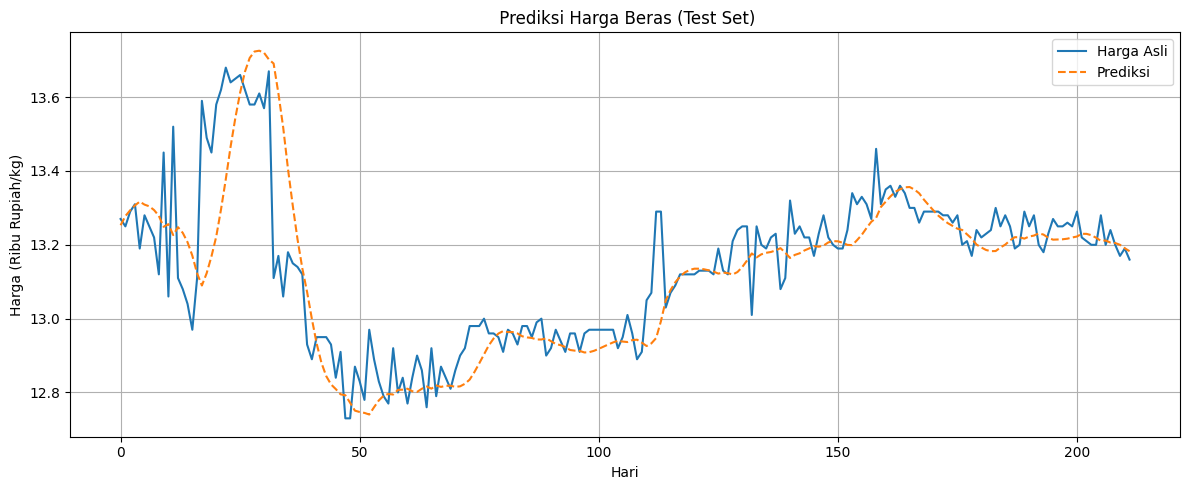

,tanggal,harga_prediksi
0,2024-05-01,13.171578
1,2024-05-02,13.161736
2,2024-05-03,13.151527
3,2024-05-04,13.141580
4,2024-05-05,13.131447


In [30]:
#  Set Seed untuk Reproducibility 
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# 1. Load Data 
df_beras = pd.read_excel("/kaggle/input/dataset/dataset_harga_beras.xlsx", sheet_name="Sheet1")
df_beras.columns = [col.strip() for col in df_beras.columns]
df_beras = df_beras.rename(columns={df_beras.columns[0]: 'tanggal', df_beras.columns[1]: 'harga'})
df_beras['tanggal'] = pd.to_datetime(df_beras['tanggal'], dayfirst=True)
df_beras = df_beras.sort_values('tanggal').reset_index(drop=True)
df_beras['harga'] = pd.to_numeric(df_beras['harga'], errors='coerce')
df_beras = df_beras.dropna().reset_index(drop=True)

#  Statistik Sebelum Normalisasi
print(" Statistik Sebelum Normalisasi:")
print(df_beras[['harga']].describe())

#  2. Preprocessing 
harga = df_beras['harga'].values.reshape(-1, 1)
scaler_harga = MinMaxScaler()
harga_scaled = scaler_harga.fit_transform(harga)

# Statistik Setelah Normalisasi
df_scaled = pd.DataFrame(harga_scaled, columns=['harga_normalized'])
print("\n Statistik Setelah Normalisasi:")
print(df_scaled.describe())

# -3. Create Sequences 
def create_lagged_dataset(data, time_steps=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 30
X, y = create_lagged_dataset(harga_scaled, time_steps)

# Print dimensi hasil sequence
print(f"\nJumlah sampel setelah sliding window: {X.shape[0]} sampel")
print(f"Dimensi input (X): {X.shape}")      # Bentuk: (jumlah sampel, 30, 1)
print(f"Dimensi output (y): {y.shape}")     # Bentuk: (jumlah sampel, 1)


#  4. Train-Test Split 
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Build & Train Model 
model_beras = Sequential([
    LSTM(64, input_shape=(time_steps, 1)),
    Dropout(0.2),
    Dense(1)
])
model_beras.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model_beras.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=0
)

# 6. Evaluation 
y_pred_scaled = model_beras.predict(X_test)
y_pred = scaler_harga.inverse_transform(y_pred_scaled)
y_true = scaler_harga.inverse_transform(y_test)

mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE  : {mae:.2f} ribu")
print(f"MAPE : {mape:.2f}%")
print(f"R²    : {r2:.4f}")

#  7. Visualisasi 
plt.figure(figsize=(12, 5))
plt.plot(y_true, label='Harga Asli')
plt.plot(y_pred, label='Prediksi', linestyle='--')
plt.title(" Prediksi Harga Beras (Test Set)")
plt.xlabel("Hari")
plt.ylabel("Harga (Ribu Rupiah/kg)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#  8. Simpan Model & Scaler 
save_model(model_beras, "lstm_price_model.h5")
joblib.dump(scaler_harga, "scaler_price")


# 9. Prediksi 546 Hari ke Depan 
n_forecast = 546
input_seq = harga_scaled[-time_steps:].reshape(1, time_steps, 1)
predictions = []

for _ in range(n_forecast):
    pred = model_beras.predict(input_seq, verbose=0)
    predictions.append(pred[0][0])
    input_seq = np.append(input_seq[:, 1:, :], [[pred[0]]], axis=1)

forecast = scaler_harga.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
forecast_dates = pd.date_range(start=df_beras['tanggal'].max() + pd.Timedelta(days=1), periods=n_forecast)

df_forecast_beras = pd.DataFrame({
    'tanggal': forecast_dates,
    'harga_prediksi': forecast
})
df_forecast_beras.to_csv("/kaggle/working/harga_beras_forecast.csv", index=False)
df_forecast_beras.head()

In [31]:
# Karakteristik data harga beras
jumlah_awal = len(harga)  # sebelum cleaning
missing_values = np.isnan(harga).sum()
jumlah_bersih = len(df_beras)

print("Karakteristik Data Harga Beras:")
print(f"- Jumlah data awal              : {jumlah_awal}")
print(f"- Missing values                : {missing_values}")
print(f"- Jumlah data setelah cleaning : {jumlah_bersih}")

Karakteristik Data Harga Beras:
- Jumlah data awal              : 1088
- Missing values                : 0
- Jumlah data setelah cleaning : 1088


In [32]:
# Hitung statistik prediksi harga beras (hasil inverse dari scaler)
harga_max = forecast.max()
harga_min = forecast.min()
harga_mean = forecast.mean()

# Tampilkan dalam format tabel (Rp/kg)
print(" Statistik Prediksi Harga Beras (Rp/kg):")
print(f"Harga Maksimum   : {harga_max:.2f}")
print(f"Harga Minimum    : {harga_min:.2f}")
print(f"Harga Rata-rata  : {harga_mean:.2f}")


 Statistik Prediksi Harga Beras (Rp/kg):
Harga Maksimum   : 13.17
Harga Minimum    : 11.03
Harga Rata-rata  : 11.42


**CEK ENV**

In [33]:
import platform
import os
import psutil
import torch
import subprocess

# CPU Info
print("CPU Info:", platform.processor())

# Jumlah core
print("CPU Cores:", os.cpu_count())

# RAM Info
ram_gb = round(psutil.virtual_memory().total / (1024 ** 3), 2)
print("RAM (GB):", ram_gb)

# GPU Info
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("GPU Memory (GB):", round(torch.cuda.get_device_properties(0).total_memory / 1e9, 2))
else:
    print("No GPU detected")

# OS Info
print("OS:", platform.system(), platform.release())
print("Python Version:", platform.python_version())

# Installed libraries
print("\n=== Installed Libraries (Top 10) ===")
!pip list | head -n 20

CPU Info: x86_64
CPU Cores: 4
RAM (GB): 31.35
GPU Name: Tesla T4
GPU Memory (GB): 15.83
OS: Linux 6.6.56+
Python Version: 3.11.11

=== Installed Libraries (Top 10) ===
Package                            Version             Editable project location
---------------------------------- ------------------- -------------------------
absl-py                            1.4.0
accelerate                         1.3.0
aiofiles                           22.1.0
aiohappyeyeballs                   2.6.1
aiohttp                            3.11.16
aiosignal                          1.3.2
aiosqlite                          0.21.0
alabaster                          1.0.0
albucore                           0.0.23
albumentations                     2.0.4
ale-py                             0.10.1
alembic                            1.15.2
altair                             5.5.0
annotated-types                    0.7.0
annoy                              1.17.3
ansicolors                         1.1.8
antlr4

In [34]:
import pkg_resources

packages = [
    'pandas', 'numpy', 'torch', 'torch_geometric', 'torch_geometric_temporal',
    'tqdm', 'scikit-learn', 'seaborn', 'matplotlib', 'networkx', 'geopandas'
]

for p in packages:
    try:
        print(f"{p}: {pkg_resources.get_distribution(p).version}")
    except:
        print(f"{p}: not installed")

pandas: 2.2.3
numpy: 1.26.4
torch: 2.5.1+cu124
torch_geometric: not installed
torch_geometric_temporal: not installed
tqdm: 4.67.1
scikit-learn: 1.2.2
seaborn: 0.12.2
matplotlib: 3.7.5
networkx: 3.4.2
geopandas: 0.14.4
